In [ ]:
# As of 10/22/18, this notebook is obsolete.  
# It forked off from http://localhost:8820/notebooks/projects/demographics/Voting-2018.ipynb#
# before that notebook was changed to have 'reg_date' be pre-parsed.
# The only reason it hasn't been deleted yet is that it was in the middle of computing 
# a GeoDataFrame to work towards distributing the dots into census blocks (see vdf_2018_08_gj)
# The source code for that was copied into http://localhost:8820/notebooks/projects/demographics/Voting-2018.ipynb#
# while it was computing a dotmap and needs to be tested before this is deleted.  

In [15]:
# Boilerplate from Randy cheatsheet at https://docs.google.com/document/d/1utZuLHcKQEZNXTQLOysTNCxTHrqxczAUymmtplpn27Q/edit#
import pandas as pd
import geopandas as gpd
import numpy as np
from geopandas import GeoSeries, GeoDataFrame
import re
%matplotlib inline
pd.set_option('display.max_columns', 500)

# Wide display
from IPython.core.display import display, HTML
display(HTML("<style>#notebook-container { margin-left:-14px; width:calc(100% + 27px) !important; }</style>"))

In [16]:
import pandas as pd
import csv, json, os, math, numbers, pandas, re, scipy, scipy.sparse, shutil
import struct, subprocess, sys, threading, time, urllib2
import sqlite3, thread, urllib

def exec_ipynb(filename_or_url):
    nb = (urllib2.urlopen(filename_or_url) if re.match(r'https?:', filename_or_url) else open(filename_or_url)).read()
    jsonNb = json.loads(nb)
    #check for the modified formatting of Jupyter Notebook v4
    if(jsonNb['nbformat'] == 4):
        exec '\n'.join([''.join(cell['source']) for cell in jsonNb['cells'] if cell['cell_type'] == 'code']) in globals()
    else:
        exec '\n'.join([''.join(cell['input']) for cell in jsonNb['worksheets'][0]['cells'] if cell['cell_type'] == 'code']) in globals()

exec_ipynb('timelapse-utilities.ipynb')

In [17]:
def get_segments_from_ring(r):
    ret = set()
    for i in range(0, len(r)):
        ret.add((r[i - 1][0], r[i - 1][1], r[i][0], r[i][1]))
    return ret

def get_segments_from_polygon(p):
    return set.union(*[get_segments_from_ring(r) for r in p])

def get_segments_from_multipolygon(mp):
    return set.union(*[get_segments_from_polygon(p) for p in mp])

def get_segments(g):
    if 'features' in g:
        return set.union(*[get_segments(f) for f in g['features']])
    elif 'geometry' in g:
        if g['geometry']['type'] == 'Polygon':
            return get_segments_from_polygon(g['geometry']['coordinates'])
        elif g['geometry']['type'] == 'MultiPolygon':
            return get_segments_from_multipolygon(g['geometry']['coordinates'])
        else:
            raise Exception('unrecognized geometry type %s' % g['geometry']['type'])
    else:
        raise 'unrecognized type'
        
def LonLatToWebMercator(lon, lat):
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

def WebMercatorToLonLat(x,y):
    lat = math.atan(math.exp((128.0 - y) * math.pi / 128.0)) * 360.0 / math.pi - 90.0
    lon = x * 360.0 / 256.0 - 180.0
    return [lon, lat]

def project_and_binarize_segment(segment, dest):
    (x1, y1) = LonLatToWebMercator(segment[0], segment[1])
    (x2, y2) = LonLatToWebMercator(segment[2], segment[3])
    dest.write(struct.pack('<ffff', x1, y1, x2, y2))

def binarize_geojson_outlines(src, dest):
    gj = json.load(open(src))
    print 'Read %d features from %s' % (len(gj['features']), src)
    segments = get_segments(gj)
    print '%d segments' % len(segments)

    try:
        os.makedirs(os.path.dirname(dest))
    except OSError:
        pass
        
    out = open(dest + '.tmp', 'w')
    for segment in segments:
        project_and_binarize_segment(segment, out)
    out.close()
    os.rename(dest + '.tmp', dest)
    print 'Created %s (%d segments)' % (dest, os.stat(dest).st_size / 16)
        

In [18]:
pandas.options.display.max_colwidth = 300
pandas.set_option('display.max_columns', 500)

# Read in 2018 US House boundaries

In [11]:
ush_2018 = gpd.read_file('voting/Remedial Plan Shapefile.shp').to_crs(epsg=4326)

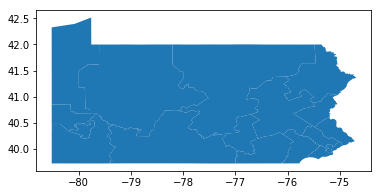

In [12]:
ush_2018.plot()

In [13]:
ush_2018

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,F18_POP,F18_AP_BLK,NH18_WHT,IDEAL_VALU,DEVIATION,F_DEVIATIO,F_18_AP_BL,F_NH18_WHT,geometry
0,1,655.201721,01,1.0,None,None,705687,543412,20074,474616,705688.0,-1.0,-0.000001,0.036941,0.873400,"POLYGON ((-75.48405700000001 40.418451, -75.479192 40.422939, -75.479049 40.423073, -75.475499 40.426399, -75.473145 40.428563, -75.472915 40.428775, -75.471053 40.430488, -75.471035 40.430503, -75.470972 40.430561, -75.469026 40.432359, -75.467159 40.434264, -75.46715 40.434274, -75.467108 40.4..."
1,2,65.945671,02,1.0,None,None,705688,526334,135399,258603,705688.0,0.0,0.000000,0.257249,0.491329,"POLYGON ((-74.980688 40.065007, -74.98070199999999 40.064878, -74.980706 40.064838, -74.980718 40.06472, -74.98073100000001 40.064592, -74.98081000000001 40.064389, -74.98090500000001 40.064269, -74.981022 40.063818, -74.981139 40.063683, -74.98114 40.063368, -74.98090500000001 40.06300700000001..."
2,3,54.538364,03,1.0,None,None,705688,568892,326217,187806,705688.0,0.0,0.000000,0.573425,0.330126,"POLYGON ((-75.206968 40.011372, -75.206914 40.011416, -75.20687100000001 40.01144800000001, -75.20679199999999 40.011512, -75.20628600000001 40.01192300000001, -75.206405 40.012002, -75.207599 40.012719, -75.207628 40.012736, -75.207728 40.012805, -75.20800800000001 40.012997, -75.20864899999999..."
3,4,480.801880,04,1.0,None,None,705687,543711,49311,443923,705688.0,-1.0,-0.000001,0.090693,0.816469,"POLYGON ((-75.48405700000001 40.418451, -75.48292499999999 40.417938, -75.48288700000001 40.417923, -75.482485 40.417686, -75.480785 40.416685, -75.47984099999999 40.41613, -75.477323 40.414648, -75.47653 40.414181, -75.474388 40.41297900000001, -75.47425800000001 40.412907, -75.47126 40.41114, ..."
4,5,221.704346,05,1.0,None,None,705688,541035,116060,377905,705688.0,0.0,0.000000,0.214515,0.698485,"POLYGON ((-75.502135 39.954367, -75.501051 39.954861, -75.499427 39.95560300000001, -75.49780199999999 39.956345, -75.496765 39.956819, -75.496719 39.95684, -75.495532 39.957382, -75.49434599999999 39.957924, -75.4939 39.958128, -75.49374299999999 39.958195, -75.493617 39.958253, -75.492351 39.9..."
5,6,922.566833,06,1.0,None,None,705688,528267,36673,420028,705688.0,0.0,0.000000,0.069421,0.795106,"POLYGON ((-75.46172900000001 40.103035, -75.461809 40.10247400000001, -75.461798 40.102346, -75.461795 40.102324, -75.461789 40.102255, -75.461788 40.102059, -75.46183000000001 40.101769, -75.461995 40.101498, -75.462361 40.101105, -75.462475 40.10095700000001, -75.46263 40.100578, -75.462637000..."
6,7,867.563293,07,1.0,None,None,705688,545100,32094,435449,705688.0,0.0,0.000000,0.058877,0.798842,"POLYGON ((-75.196803 40.60858, -75.19714999999999 40.60841600000001, -75.197287 40.608351, -75.19743200000001 40.60828300000001, -75.19759500000001 40.608205, -75.197654 40.608177, -75.197755 40.608129, -75.197802 40.60811200000001, -75.19782499999999 40.608103, -75.198019 40.608016, -75.198635 ..."
7,8,1117.711420,10,1.0,None,None,705688,545746,56209,446632,705688.0,0.0,0.000000,0.102995,0.818388,"POLYGON ((-76.701624 40.658082, -76.701566 40.658048, -76.70150700000001 40.658014, -76.70093300000001 40.65768, -76.698863 40.656477, -76.698173 40.656076, -76.696916 40.655321, -76.693145 40.653057, -76.691889 40.652303, -76.691603 40.652118, -76.69074600000002 40.651565, -76.69056 40.651445, ..."
8,9,1545.007080,11,1.0,None,None,705688,533533,18009,476409,705688.0,0.0,0.000000,0.033754,0.892933,"POLYGON ((-76.72162 40.12007, -76.721349 40.120606, -76.72094500000001 40.12141, -76.72054 40.122214, -76.720279 40.122734, -76.72027 40.122751, -76.720266 40.122757, -76.72025600000001 40.122778, -76.72025300000001 40.122785, -76.720139 40.123012, -76.72002500000001 40.123238, -76.7200200000000..."
9,10,9975.768550,12,1.0,None,None,705688,560669,12883,527131,705688.0,0.0,0.000000,0.022978,0.940182,"POLYGON ((-77.939424 40.775485, -77.93929 40.775576, -77.936916 40.777277, -77.93570200000001 40.778148, -77.927571 40.784001, -77.927249 40.7

In [14]:
# Create a GeoDataFrame that just has DISTRICT and geometry
ush_out_2018 = gpd.GeoDataFrame(ush_2018[['DISTRICT']], geometry=ush_2018.geometry,crs={'init': 'epsg:4326'})

In [15]:
ush_out_2018

,DISTRICT,geometry
0,01,"POLYGON ((-75.48405700000001 40.418451, -75.479192 40.422939, -75.479049 40.423073, -75.475499 40.426399, -75.473145 40.428563, -75.472915 40.428775, -75.471053 40.430488, -75.471035 40.430503, -75.470972 40.430561, -75.469026 40.432359, -75.467159 40.434264, -75.46715 40.434274, -75.467108 40.4..."
1,02,"POLYGON ((-74.980688 40.065007, -74.98070199999999 40.064878, -74.980706 40.064838, -74.980718 40.06472, -74.98073100000001 40.064592, -74.98081000000001 40.064389, -74.98090500000001 40.064269, -74.981022 40.063818, -74.981139 40.063683, -74.98114 40.063368, -74.98090500000001 40.06300700000001..."
2,03,"POLYGON ((-75.206968 40.011372, -75.206914 40.011416, -75.20687100000001 40.01144800000001, -75.20679199999999 40.011512, -75.20628600000001 40.01192300000001, -75.206405 40.012002, -75.207599 40.012719, -75.207628 40.012736, -75.207728 40.012805, -75.20800800000001 40.012997, -75.20864899999999..."
3,04,"POLYGON ((-75.48405700000001 40.418451, -75.48292499999999 40.417938, -75.48288700000001 40.417923, -75.482485 40.417686, -75.480785 40.416685, -75.47984099999999 40.41613, -75.477323 40.414648, -75.47653 40.414181, -75.474388 40.41297900000001, -75.47425800000001 40.412907, -75.47126 40.41114, ..."
4,05,"POLYGON ((-75.502135 39.954367, -75.501051 39.954861, -75.499427 39.95560300000001, -75.49780199999999 39.956345, -75.496765 39.956819, -75.496719 39.95684, -75.495532 39.957382, -75.49434599999999 39.957924, -75.4939 39.958128, -75.49374299999999 39.958195, -75.493617 39.958253, -75.492351 39.9..."
5,06,"POLYGON ((-75.46172900000001 40.103035, -75.461809 40.10247400000001, -75.461798 40.102346, -75.461795 40.102324, -75.461789 40.102255, -75.461788 40.102059, -75.46183000000001 40.101769, -75.461995 40.101498, -75.462361 40.101105, -75.462475 40.10095700000001, -75.46263 40.100578, -75.462637000..."
6,07,"POLYGON ((-75.196803 40.60858, -75.19714999999999 40.60841600000001, -75.197287 40.608351, -75.19743200000001 40.60828300000001, -75.19759500000001 40.608205, -75.197654 40.608177, -75.197755 40.608129, -75.197802 40.60811200000001, -75.19782499999999 40.608103, -75.198019 40.608016, -75.198635 ..."
7,10,"POLYGON ((-76.701624 40.658082, -76.701566 40.658048, -76.70150700000001 40.658014, -76.70093300000001 40.65768, -76.698863 40.656477, -76.698173 40.656076, -76.696916 40.655321, -76.693145 40.653057, -76.691889 40.652303, -76.691603 40.652118, -76.69074600000002 40.651565, -76.69056 40.651445, ..."
8,11,"POLYGON ((-76.72162 40.12007, -76.721349 40.120606, -76.72094500000001 40.12141, -76.72054 40.122214, -76.720279 40.122734, -76.72027 40.122751, -76.720266 40.122757, -76.72025600000001 40.122778, -76.72025300000001 40.122785, -76.720139 40.123012, -76.72002500000001 40.123238, -76.7200200000000..."
9,12,"POLYGON ((-77.939424 40.775485, -77.93929 40.775576, -77.936916 40.777277, -77.93570200000001 40.778148, -77.927571 40.784001, -77.927249 40.784218, -77.922938 40.787312, -77.921674 40.78822, -77.920844 40.788816, -77.920072 40.789364, -77.919318 40.7899, -77.917469 40.791233, -77.916546 40.7918..."


In [16]:
# Write out the 2018 US House geometry as a geojson file
ush_out_2018.to_file('voting/pa_us_house_boundaries_2018.geojson', driver="GeoJSON")

In [17]:
binarize_geojson_outlines('voting/pa_us_house_boundaries_2018.geojson', 
                          'voting/pa_us_house_boundaries_2018.bin')

Read 18 features from voting/pa_us_house_boundaries_2018.geojson
112242 segments
Created voting/pa_us_house_boundaries_2018.bin (112242 segments)


# Deal with voting file from county

In [2]:
# Key is string canonical address, value is a map: {'canonical_in_census_db': True/False,'canonical_in_google_db': True/False, 'other_addr_strings':Set, 'census_value':str, 'google_value':str
canonical_addr_map={}

In [45]:
def canonicalize_string(text):
    # Remove any leading or trailing whitespace, replace any internal whitespace with single spaces, upcase it all
    ret = re.sub("^\s+|\s+$", "", text)
    ret = re.sub("\s+", " ", ret)
    return ret.upper()

In [72]:
# Try to load canonical_addr_map originally created by 
#  http://localhost:8820/notebooks/projects/demographics/Fixup%20Address%20DB.ipynb
import pickle
pickle_file_path = 'assessments/canonical_addr_map_b.pickle'

In [47]:
# Load in canonical_addr_map
with open(pickle_file_path, 'rb') as handle:
    canonical_addr_map = pickle.load(handle)

In [73]:
# Save out canonical_addr_map
with open(pickle_file_path, 'wb') as handle:
    pickle.dump(canonical_addr_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
# From http://localhost:8820/notebooks/projects/demographics/Allegheny%20County%20Property%20Assessments-AW9.ipynb

# assessments/cd/AC Property Assessments_10012017.xls (which is actually TDF) from Amy Gottsegen and Randy Sargent buying a CD from the county assessors office
# assessments/Allegheny_County_Parcel_Boundaries.geojson from https://data.wprdc.org/dataset/allegheny-county-parcel-boundaries
import array, csv, datetime, json, math, numpy, os, random, re 
from dateutil.parser import parse
from shapely.geometry import mapping, shape
from PIL import Image
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas,numbers
from operator import itemgetter, attrgetter
import string
import calendar,time
from IPython.core.display import HTML

# Use geopandas.  Boilerplate from https://docs.google.com/document/d/1utZuLHcKQEZNXTQLOysTNCxTHrqxczAUymmtplpn27Q/edit#heading=h.f50xoxwmcir
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
%matplotlib inline

pd.options.display.max_colwidth = 300
pd.options.display.max_rows = 100
pd.set_option('display.max_columns', 500)

# Built-in time handling fails for times before 1900.  Use arrow instead.  
# See https://arrow.readthedocs.io/en/latest/ for info
import arrow
import dateparser

def LonLatToPixelXY(lonlat):
    (lon, lat) = lonlat
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

# This does the same as above, but takes a GeoJSON point (which is what centroid returns)
def PointToPixelXY(point):
    lon=point.x
    lat=point.y
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

def GetCentroid(geometry):
    s = shape(geometry)
    return (s.centroid.x, s.centroid.y)   

def GetEpoch(date):
    return (date - datetime.datetime(1970, 1, 1)).total_seconds()

def HexToRgb(hex_string):
    rgb = colors.hex2color(hex_string)
    r,g,b = tuple([int(255*x) for x in rgb])
    return (r,g,b)

In [97]:
vrec = voter_map[voter_map.keys()[0]]
regdate = vrec['reg_date']
rdate = dateparser.parse(regdate)
print "%r %r %r" % (regdate, rdate, GetEpoch(rdate))

'12/9/2011' datetime.datetime(2011, 12, 9, 0, 0) 1323388800.0


In [21]:
# Google addresses with the addition of using canonical_addr_map as cache
# Original version was from 
#  http://localhost:8820/notebooks/projects/demographics/Allegheny%20County%20Property%20Assessments-AW9.ipynb#
from shapely.geometry import Point
import collections


# Google geocoding API to geocode an address
# Assumes key is in google_api_key.txt
# Use as second level lookup only for those which fail census lookup

re_noalnum = re.compile('^([^\w]+)$')

def geocode_address_google(address):
    if(pandas.isnull(address) or re_noalnum.match(address)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(address)
        return None

    # String canonicalize the address
    caddr = canonicalize_string(address)

    # Check if we already have a value in canonical_addr_map, if so return it
    if(caddr in canonical_addr_map and canonical_addr_map[caddr]['google_value']):
        result = json.loads(canonical_addr_map[caddr]['google_value'])
    else:
        # Not yet in canonical_addr_map, fetch from sqlite DB or google address lookup service
        try:
            geocode_address_google.conn
        except:
            geocode_address_google.conn = sqlite3.connect('geocoding_cache')
            geocode_address_google.cur = geocode_address_google.conn.cursor()
            geocode_address_google.cur.execute(('CREATE TABLE IF NOT EXISTS kvs'
                                         ' (key PRIMARY KEY, value)'
                                         ' WITHOUT ROWID;'))
            geocode_address_google.conn.commit()

        geocode_address_google.cur.execute('SELECT value FROM kvs WHERE key=?', (caddr,))
        rows = geocode_address_google.cur.fetchall()
        if rows:
            #print "Google: Found %r in cache" % (caddr)
            gval = rows[0][0]
        else:
            # Not in sqlite, ask google address service
            #print "Google: %r not found in cache, fetching" % (address)

            api_key = open('google-api-key-do-not-commit.txt').read()
            payload = {'address':caddr, 'key':api_key}
            result = json.load(urllib2.urlopen('https://maps.googleapis.com/maps/api/geocode/json?%s' % urllib.urlencode(payload)))
            # Keep the stringified version for the DB/canonical_addr_map
            gval = json.dumps(result)
            geocode_address_google.cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                                         ' VALUES (?, ?);'),
                                         (caddr, gval))
            geocode_address_google.conn.commit()
            
            # If the result succeeded and generated a formatted address, cache under that key too
            try:
                if(result['status']=='OK'):
                    if(len(result['results'])== 1):
                        canonical = result['results'][0]['formatted_address']
                        #print "Google: Storing canonical addr of %r for %r" % (canonical, address)
                        geocode_address_google.cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                                                             ' VALUES (?, ?);'),
                                                             (canonical, gval))
                        geocode_address_google.conn.commit()
                    else:
                        print "Google: Fetch %r seemed to succeed, but results empty or non-unique" % (address)

                else:
                    print "Google: Fetch %r failed" % (address)
                
            except:
                #pass
                raise
                
        # We had to resort to sqlite/google address service.  Add gval to canonical_addr_map
        if(caddr not in canonical_addr_map):
            canonical_addr_map[caddr]={'canonical_in_census_db':False,'canonical_in_google_db': True, 
                                       'census_value':None, 'google_value':gval}
        else:
            # Already there, presumably for census.  Add google value 
            canonical_addr_map[caddr]['canonical_in_google_db']=True
            canonical_addr_map[caddr]['google_value']=gval
 
    
    return result

def get_canonical_address_google(raw_addr):
    if(pandas.isnull(raw_addr) or re_noalnum.match(raw_addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(raw_addr)
        return None

    try:
        result=geocode_address_google(raw_addr)
        if(result['status']=='OK' and len(result['results'])== 1):
            return(result['results'][0]['formatted_address'])
        else:
            return None
    except:
        return None

def get_canonical_zip_google(addr):
    if(pandas.isnull(addr) or re_noalnum.match(addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None

    try:
        result=geocode_address_google(addr)
        if(result['status']=='OK' and len(result['results'])== 1):
            addr_comps = result['results'][0]['address_components']
            for i in range(0, len(addr_comps)):
                if('postal_code' in addr_comps[i]['types']):
                    return addr_comps[i]['short_name']
        
        return None
    except:
        return None
    
def get_canonical_coords_google(addr):
    if(pandas.isnull(addr) or re_noalnum.match(addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None

    try:
        result=geocode_address_google(addr)
        if(result['status']=='OK' and len(result['results'])== 1):
            latlon = result['results'][0]['geometry']['location']
            if(latlon):
                return(Point(latlon['lng'], latlon['lat']))
        return None
    except:
        return None


In [122]:
str(get_canonical_coords('3990 C 5TH AVE LITCHFIELD TOWER PITTSBURGH PA 15213'))

'POINT (-79.95579499999999 40.443695)'

In [22]:
# Census addresses with the addition of using canonical_addr_map as cache
# Original version was from 
#  http://localhost:8820/notebooks/projects/demographics/Allegheny%20County%20Property%20Assessments-AW9.ipynb#

# Uses Census geocoding API to geocode an address

import sqlite3
import urllib,urllib2
import json
from shapely.geometry import Point
import collections

# Match if the string contains no alphanumerics
re_noalnum = re.compile('^([^\w]+)$')

def geocode_address_census(address):
    if(pandas.isnull(address) or re_noalnum.match(address)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(address)
        return None

    # String canonicalize the address
    caddr = canonicalize_string(address)

    # Check if we already have a value in canonical_addr_map, if so return it
    if(caddr in canonical_addr_map and canonical_addr_map[caddr]['census_value']):
        result = json.loads(canonical_addr_map[caddr]['census_value'])
    else:
        # Not yet in canonical_addr_map, fetch from sqlite DB or census address lookup service
        try:
            geocode_address_census.sqlite
        except:
            geocode_address_census.sqlite = {}

        tpid = '%d.%s' % (os.getpid(), thread.get_ident())
        if not tpid in geocode_address_census.sqlite:
            conn = sqlite3.connect('geocoding_cache_census')
            cur = conn.cursor()
            geocode_address_census.sqlite[tpid] = { 'conn': conn, 'cur': cur }

            cur.execute(('CREATE TABLE IF NOT EXISTS kvs'
                         ' (key PRIMARY KEY, value)'
                         ' WITHOUT ROWID;'))
            conn.commit()
        else:
            conn = geocode_address_census.sqlite[tpid]['conn']
            cur = geocode_address_census.sqlite[tpid]['cur']

        cur.execute('SELECT value FROM kvs WHERE key=?', (caddr,))
        rows = cur.fetchall()
        if rows:
            cval = rows[0][0]
        else:
            payload = {'address':caddr, 'benchmark':4, 'format':'json'}
            result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
            cval = json.dumps(result)

            cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                         ' VALUES (?, ?);'),
                        (caddr, cval))
            conn.commit()

            if len(result['result']['addressMatches']) == 1:
                canonical = result['result']['addressMatches'][0]['matchedAddress']
                cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                             ' VALUES (?, ?);'),
                             (canonical, cval))
                conn.commit()
            
        # We had to resort to sqlite/google address service.  Add cval to canonical_addr_map
        if(caddr not in canonical_addr_map):
            canonical_addr_map[caddr]={'canonical_in_census_db':True,'canonical_in_google_db': False, 
                                       'census_value':cval, 'google_value':None}
        else:
            # Already there, presumably for google.  Add census value 
            canonical_addr_map[caddr]['canonical_in_census_db']=True
            canonical_addr_map[caddr]['census_value']=cval

    
    return result

def cache_canonical_addresses(addrs):
    t = SimpleThreadPoolExecutor(25)
    for addr in addrs:
        if(not (pandas.isnull(addr) or re_noalnum.match(addr))):
            t.submit(geocode_address_census, addr)
        else:
            #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
            pass
    t.shutdown()

def get_canonical_address_census(raw_addr):
    if(pandas.isnull(raw_addr) or re_noalnum.match(raw_addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(raw_addr)
        return None

    try:
        result=geocode_address_census(raw_addr)
        if len(result['result']['addressMatches']) == 1:
            return(result['result']['addressMatches'][0]['matchedAddress'])
        else:
            return None
    except:
        return None

def get_canonical_zip_census(addr):
    try:
        result=geocode_address_census(addr)
        if len(result['result']['addressMatches']) == 1:
            return(result['result']['addressMatches'][0]['addressComponents']['zip'])
        else:
            return None
    except:
        return None

    
def get_canonical_coords_census(addr):
    try:
        result=geocode_address_census(addr)
        if len(result['result']['addressMatches']) == 1:
            coords = result['result']['addressMatches'][0]['coordinates']
            return(Point(coords['x'], coords['y']))
        else:
            return None
    except:
        return None

################################################################################################################
# These can handle being passed a map with either census or google in it and dispatch to the right service

# TODO: Think if this is the right behavior: If handed a regular string do census lookup
# If handed a map, return census if non-null, then google if non-null
def get_canonical_address(addr):
    if(pandas.isnull(addr) or ((not isinstance(addr, collections.Mapping) and re_noalnum.match(addr)))):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None

    if(isinstance(addr, collections.Mapping)):
        if('census' in addr and not pd.isnull(addr['census'])):
            return addr['census']
        elif('google' in addr and not pd.isnull(addr['google'])):
            return addr['google']
    else:
        return(get_canonical_address_census(addr))

def get_canonical_zip(addr):
    if(pandas.isnull(addr) or ((not isinstance(addr, collections.Mapping) and re_noalnum.match(addr)))):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None
    if(isinstance(addr, collections.Mapping)):
        if('census' in addr and not pd.isnull(addr['census'])):
            return get_canonical_zip_census(addr['census'])
        elif('google' in addr and not pd.isnull(addr['google'])):
            return get_canonical_zip_google(addr['google'])
    else:
        return(get_canonical_zip_census(addr))

def get_canonical_coords(addr):
    if(pandas.isnull(addr) or ((not isinstance(addr, collections.Mapping) and re_noalnum.match(addr)))):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None
    
    if(isinstance(addr, collections.Mapping)):
        if('census' in addr and not pd.isnull(addr['census'])):
            return get_canonical_coords_census(addr['census'])
        elif('google' in addr and not pd.isnull(addr['google'])):
            return get_canonical_coords_google(addr['google'])
    else:
        return(get_canonical_coords_census(addr))

def canonicalize_addr_colset(df, col_arr, out_colname):
    for  col_name in col_arr:
        df[col_name]=df[col_name].astype(basestring)
        df[col_name].fillna('', inplace=True)

    df[out_colname] = df[col_arr].apply(lambda x: get_canonical_address_census(' '.join(x)), axis=1)
    
    

In [23]:
# Create 'property_address_raw' and 'owner_address_raw' columns.  Call once per dataframe before calling
# canonicalize_addrs
def merge_addr_colset(df, col_arr, out_colname):
    for  col_name in col_arr:
        df[col_name]=df[col_name].astype(basestring)
        df[col_name].fillna('', inplace=True)

    df[out_colname] = df[col_arr].apply(lambda x: canonicalize_string(' '.join(x)), axis=1)
    # Fix up PGH to be PITTSBURGH
    df[out_colname] = df[out_colname].str.replace('\s*PGH\s*,', ' PITTSBURGH,', regex=True)


# Deal with various versions of the voter DB

In [24]:
voters_addr_cols=['House__', 'HouseNoSuffix', 'StreetNameComplete' ,'City', 'State','Zip_Code']
voters_addr_dtype={'House__':numpy.str, 'HouseNoSuffix':numpy.str, 'StreetNameComplete':numpy.str ,'City':numpy.str, 'State':numpy.str,'Zip_Code':numpy.str}

voters_info = {
    '2018-08': {'path': 'voters/2018-08-cd/VOTERS8_14_18.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_addr_dtype
               },
    '2018-03': {'path': 'voters/2018-03-cd/VOTERS3_5_18.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_addr_dtype
               },
    '2017-11': {'path': 'voters/2017-11-cd/VOTERS11_30_2017.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_addr_dtype
               },
}

In [25]:
# Do fixup on Pitt addresses
def fixup_pitt_addresses(df):
    df['address_raw'] = df['address_raw'].str.replace('(^.*((PITT TOWERS)|(5TH AVE-MCCORMICK HALL)|(HOLLAND HALL)) PITTSBURGH PA 15213$)', '3990 FIFTH AVE PITTSBURGH PA 15213', regex=True)
    df['address_raw'] = df['address_raw'].str.replace('(^.*AMOS HALL PITTSBURGH PA 15213$)', '3959 FIFTH AVE PITTSBURGH PA 15260', regex=True)
    df['address_raw'] = df['address_raw'].str.replace('(^.*SUTHERLAND HALL PITTSBURGH PA 15213$)', '3725 SUTHERLAND DR PITTSBURGH PA 15213', regex=True)
    
    

In [26]:
def load_voters_info(month_str):
    if(not month_str in voters_info):
        print "No entry for %s in voters_info" % (month_str)
    path = voters_info[month_str]['path']
    voters_info[month_str]['df'] = pandas.read_csv(path,sep='\t',dtype=voters_info[month_str]['dtype']).set_index('ID_Number')
    merge_addr_colset(voters_info[month_str]['df'], voters_info[month_str]['addr_cols'], 'address_raw')
    fixup_pitt_addresses(voters_info[month_str]['df'])
    return voters_info[month_str]['df']

In [69]:
# Key is voter ID, DOB:str, reg_date:str, reg_info:{month_str: {status: , party: }}, addresses:{month_str:address}}
voter_map = {}

In [52]:
def process_voting_record(apd, i, month_str):
    global voter_map

    # Generate set of interesting colnames we have in this data frame
    interesting_colnames=set(['address_raw','Voter_Status','Political_Party','Last_Date_Voted','Date_Last_Changed','Date_Of_Birth','Date_Registered'])
    colnames = set(apd.columns) & interesting_colnames

    voter_id = apd.iloc[i].name
    if(not voter_id in voter_map):
        voter_map[voter_id]={'DOB':apd['Date_Of_Birth'].iloc[i], 'reg_date':apd['Date_Registered'].iloc[i], 'reg_info':{}, 'addresses':{}}
    
    voter_map[voter_id]['reg_info'][month_str] = {'status':apd['Voter_Status'].iloc[i],'party':apd['Political_Party'].iloc[i]}
    voter_map[voter_id]['addresses'][month_str] = apd['address_raw'].iloc[i]
    
def process_all_voting_records(apd,month_str):
    for i in range(0,len(apd)):
        process_voting_record(apd, i, month_str)

In [27]:
vdf_2018_08 = load_voters_info('2018-08')

/home/rsargent/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (1,21,44) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [172]:
vdf_2018_03 = load_voters_info('2018-03')

In [168]:
vdf_2017_11 = load_voters_info('2017-11')

In [176]:
# Check we have everything
for month_str in (['2018-08','2018-03','2017-11']):
    print "%s: %s" % (month_str, voters_info[month_str].keys())

2018-08: ['df', 'path', 'addr_cols', 'dtype']
2018-03: ['df', 'path', 'addr_cols', 'dtype']
2017-11: ['df', 'path', 'addr_cols', 'dtype']


In [177]:
# Process voting records
for month_str in (['2018-03','2017-11']):
    process_all_voting_records(voters_info[month_str]['df'],month_str)

# Census Blocks

In [51]:
def addr_to_coords(addr):
    caddr = canonicalize_string(addr)
    # Try coords from census first
    coords = get_canonical_coords(caddr)
    if(not coords):
        # Didn't work, try google
        coords = get_canonical_coords_google(caddr)
    #if(coords):
    #    print "%s: %s" % (caddr,coords)
    return coords


In [48]:
canonical_addr_map['3725 SUTHERLAND DR PITTSBURGH PA 15213']

{'canonical_in_census_db': True,
 'canonical_in_google_db': False,
 'census_value': '{"result": {"addressMatches": [{"tigerLine": {"tigerLineId": "51816351", "side": "L"}, "coordinates": {"y": 40.446404, "x": -79.96392}, "matchedAddress": "3725 SUTHERLAND DR, PITTSBURGH, PA, 15213", "addressComponents": {"suffixType": "DR", "zip": "15213", "toAddress": "3701", "preQualifier": "", "preDirection": "", "city": "PITTSBURGH", "preType": "", "state": "PA", "suffixQualifier": "", "fromAddress": "3799", "streetName": "SUTHERLAND", "suffixDirection": ""}}], "input": {"benchmark": {"benchmarkName": "Public_AR_Current", "id": "4", "isDefault": false, "benchmarkDescription": "Public Address Ranges - Current Benchmark"}, "address": {"address": "3725 SUTHERLAND DR PITTSBURGH PA 15213"}}}}',
 'google_value': None}

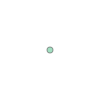

In [49]:
get_canonical_coords('3725 SUTHERLAND DR PITTSBURGH PA 15213')

3725 SUTHERLAND DR PITTSBURGH PA 15213: POINT (-79.96392 40.446404)


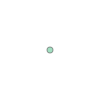

In [50]:
addr_to_coords('3725 SUTHERLAND DR PITTSBURGH PA 15213')

In [ ]:
# Create a GeoDataFrame that just has voter id and raw_address and has addr_to_coords as geometry
vdf_2018_08_gj = gpd.GeoDataFrame(vdf_2018_08['address_raw'], geometry=vdf_2018_08['address_raw'].apply(addr_to_coords),crs={'init': 'epsg:4326'})

Google: Fetch '7 ALLEGHENY CENTER PITTSBURGH PA 15212' seemed to succeed, but results empty or non-unique
Google: Fetch '81 DUANE AVE N PITTSBURGH PA 15205' seemed to succeed, but results empty or non-unique
Google: Fetch '6181 IRISHTOWN RD EXT BETHEL PARK PA 15102' seemed to succeed, but results empty or non-unique
Google: Fetch '116 SPRING RUN RD MOON TWP PA 15108' seemed to succeed, but results empty or non-unique
Google: Fetch '53 GARDEN CT VERONA PA 15147' seemed to succeed, but results empty or non-unique
Google: Fetch '7 HARRISON VLG MC KEESPORT PA 15132' seemed to succeed, but results empty or non-unique
Google: Fetch '814 E DR WEST MIFFLIN PA 15122' failed
Google: Fetch '114 RIDGE AVE NORTH VERSAILLES PA 15137' seemed to succeed, but results empty or non-unique
Google: Fetch '641 ELMSPRING CT PITTSBURGH PA 15220' seemed to succeed, but results empty or non-unique
Google: Fetch '2501 BANKS SCHOOL RD BOX WILDWOOD PA 15091' seemed to succeed, but results empty or non-unique
Googl

Google: Fetch '291 STATE RTE 908 EXT TARENTUM PA 15084' seemed to succeed, but results empty or non-unique
Google: Fetch '5406 LANTERN HILL DR EXT PITTSBURGH PA 15236' seemed to succeed, but results empty or non-unique
Google: Fetch '129 EUGENE AVE W MUNHALL PA 15120' seemed to succeed, but results empty or non-unique
Google: Fetch '59 GARDEN CT VERONA PA 15147' seemed to succeed, but results empty or non-unique
Google: Fetch '4518 MODOC ST PITTSBURGH PA 15201' seemed to succeed, but results empty or non-unique
Google: Fetch '5 BLANFORD CT PITTSBURGH PA 15206' seemed to succeed, but results empty or non-unique
Google: Fetch '211 3RD AVE RANKIN PA 15104' seemed to succeed, but results empty or non-unique
Google: Fetch '112 A WASHINGTON PL MARRIOTT PITTSBURGH PA 15219' seemed to succeed, but results empty or non-unique
Google: Fetch '3118 STATE RTE 885 CLAIRTON RD WEST MIFFLIN PA 15122' seemed to succeed, but results empty or non-unique
Google: Fetch '11 ESMOND CT PITTSBURGH PA 15206' se

Google: Fetch '1869 STAGE COURT ALLISON PARK PA 15101' seemed to succeed, but results empty or non-unique
Google: Fetch '222 MCDONALD ST MC DONALD PA 15057' seemed to succeed, but results empty or non-unique
Google: Fetch '95 HARMONY CT PITTSBURGH PA 15239' seemed to succeed, but results empty or non-unique
Google: Fetch '688 SOUTHCREST CT OR DR PITTSBURGH PA 15226' seemed to succeed, but results empty or non-unique
Google: Fetch '6 BLANFORD CT PITTSBURGH PA 15206' seemed to succeed, but results empty or non-unique
Google: Fetch '50 STEUBEN ST E PITTSBURGH PA 15205' seemed to succeed, but results empty or non-unique
Google: Fetch '12 PARKVIEW DR JT TR CT CLINTON PA 15026' seemed to succeed, but results empty or non-unique
Google: Fetch '77 D PETRIE RD CORAOPOLIS PA 15108' seemed to succeed, but results empty or non-unique
Google: Fetch '219 DOUGLAS ST WEST MIFFLIN PA 15122' seemed to succeed, but results empty or non-unique
Google: Fetch '5414 LANTERN HILL DR EXT PITTSBURGH PA 15236' s

In [53]:
len(vdf_2018_08_gj)

926152

In [56]:
len(vdf_2018_08_gj[~pd.isna(vdf_2018_08_gj.geometry)])

916522

In [58]:
len(vdf_2018_08_gj[pd.isna(vdf_2018_08_gj.geometry)])

9630

In [60]:
# Get just the ones that geolocate successfully in 15213
vdf_ok_15213_2018_08_gj = vdf_2018_08_gj[(~pd.isna(vdf_2018_08_gj.geometry)) & (vdf_2018_08_gj['address_raw'].str.contains("15213"))]

In [61]:
len(vdf_ok_15213_2018_08_gj)

26889

In [62]:
# Load geojson for census blocks in Allegheny County, find census block for each voter
ac_cb_gj = gpd.read_file('allegheny_county/tl_2010_42003_tabblock10.geojson')

In [63]:
# Do spatial join to get census block for each address 
# Example from:
#    http://localhost:8820/notebooks/projects/demographics/Census-Planning-DB-2018.ipynb
# mob_blkgroups_gj = gpd.sjoin(blkgrps_cent_gj, mob_gj, how="inner", op='within')
vdf_ok_15213_cb_2018_08_gj = gpd.sjoin(vdf_ok_15213_2018_08_gj, ac_cb_gj, how="inner", op='within')

In [64]:
vdf_ok_15213_cb_2018_08_gj[0:10]

,address_raw,geometry,index_right,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10
102892955-02,3990 FIFTH AVE PITTSBURGH PA 15213,POINT (-79.9564623 40.4427563),11283,42,003,982200,1015,420039822001015,Block 1015,G5040,U,69697,U,S,37913.0,0.0,+40.4431739,-079.9554064
108195299-02,3990 C 5TH AVE LITCHFIELD TOWER PITTSBURGH PA 15213,POINT (-79.95579499999999 40.443695),11283,42,003,982200,1015,420039822001015,Block 1015,G5040,U,69697,U,S,37913.0,0.0,+40.4431739,-079.9554064
103237742-02,3990 B 5TH AVE LITCHFIELD TOWER PITTSBURGH PA 15213,POINT (-79.95579499999999 40.443695),11283,42,003,982200,1015,420039822001015,Block 1015,G5040,U,69697,U,S,37913.0,0.0,+40.4431739,-079.9554064
107896176-02,3990 5TH AVE BRUCE HALL PITTSBURGH PA 15213,POINT (-79.95581 40.443684),11283,42,003,982200,1015,420039822001015,Block 1015,G5040,U,69697,U,S,37913.0,0.0,+40.4431739,-079.9554064
107994064-02,3990 5TH AVE SMC PITTSBURGH PA 15213,POINT (-79.95581 40.443684),11283,42,003,982200,1015,420039822001015,Block 1015,G5040,U,69697,U,S,37913.0,0.0,+40.4431739,-079.9554064
105171732-02,3990 A 5TH AVE LITCHFIELD TOWER PITTSBURGH PA 15213,POINT (-79.95579499999999 40.443695),11283,42,003,982200,1015,420039822001015,Block 1015,G5040,U,69697,U,S,37913.0,0.0,+40.4431739,-079.9554064
102894457-02,3990 B 5TH AVE LITCHFIELD TOWER PITTSBURGH PA 15213,POINT (-79.95579499999999 40.443695),11283,42,003,982200,1015,420039822001015,Block 1015,G5040,U,69697,U,S,37913.0,0.0,+40.4431739,-079.9554064
106798655-02,3990 5TH AVE SMC PITTSBURGH PA 15213,POINT (-79.95581 40.443684),11283,42,003,982200,1015,420039822001015,Block 1015,G5040,U,69697,U,S,37913.0,0.0,+40.4431739,-079.9554064
107291820-02,3990 5TH AVE SMC PITTSBURGH PA 15213,POINT (-79.95581 40.443684),11283,42,003,982200,1015,420039822001015,Block 1015,G5040,U,69697,U,S,37913.0,0.0,+40.4431739,-079.9554064
021090188-02,3990 FIFTH AVE PITTSBURGH PA 15213,POINT (-79.95581 40.443684),11283,42,003,982200,1015,420039822001015,Block 1015,G5040,U,69697,U,S,37913.0,0.0,+40.4431739,-079.9554064


In [65]:
# Get just the ones that geolocate successfully 
vdf_ok_2018_08_gj = vdf_2018_08_gj[(~pd.isna(vdf_2018_08_gj.geometry))]
vdf_ok_cb_2018_08_gj = gpd.sjoin(vdf_ok_2018_08_gj, ac_cb_gj, how="inner", op='within')

In [67]:
# Keep only the index, 'address_raw', 'GEOID10', and geometry 
vdf_ok_cb_2018_08_out_gj = gpd.GeoDataFrame(vdf_ok_cb_2018_08_gj[['address_raw','GEOID10']], geometry=vdf_ok_cb_2018_08_gj.geometry, crs={'init': 'epsg:4326'})


In [68]:
vdf_ok_cb_2018_08_out_gj

,address_raw,GEOID10,geometry
108927574-02,155 SENECA PL MARS PA 16046,420034110001038,POINT (-80.08404759999999 40.66922539999999)
108750391-02,322 OSONA LN MARS PA 16046,420034110001038,POINT (-80.08978429999999 40.6685968)
107867899-02,244 VENANGO TRL MARS PA 16046,420034110001038,POINT (-80.08884759999999 40.6676426)
020899094-02,272 VENANGO TRL MARS PA 16046,420034110001038,POINT (-80.0901774 40.6685874)
012695371-02,647 CHILLIWACK LN MARS PA 16046,420034110001038,POINT (-80.0858873 40.661459)
020404437-02,270 VENANGO TRL MARS PA 16046,420034110001038,POINT (-80.0901767 40.6684939)
001526641-02,270 VENANGO TRL MARS PA 16046,420034110001038,POINT (-80.0901767 40.6684939)
002788347-02,119 SENECA PL MARS PA 16046,420034110001038,POINT (-80.08629479999999 40.6715325)
108866580-02,155 SENECA PL MARS PA 16046,420034110001038,POINT (-80.08404759999999 40.66922539999999)
002713556-02,318 OSONA LN MARS PA 16046,420034110001038,POINT (-80.08979520000001 40.6689412)


In [69]:
vdf_ok_cb_2018_08_out_gj.to_file('voters/vdf_ok_cb_2018_08_out_gj.geojson', driver="GeoJSON")

In [74]:
# Get just the ones that do not geolocate successfully 
non_geolocatable_addrs = vdf_2018_08_gj[(pd.isna(vdf_2018_08_gj.geometry))].address_raw.unique()


In [78]:
    numpy.save("voters/non_geolocatable_addrs.npy",non_geolocatable_addrs)

# Debug

In [178]:
voter_map['002171843-02']

{'DOB': '8/19/1944',
 'addresses': {'2017-11': '137 WILTSHIRE CIR MONROEVILLE PA 15146',
  '2018-03': '137 WILTSHIRE CIR MONROEVILLE PA 15146',
  '2018-08': '137 WILTSHIRE CIR MONROEVILLE PA 15146'},
 'reg_date': '10/1/1974',
 'reg_info': {'2017-11': {'party': 'R', 'status': 'A'},
  '2018-03': {'party': 'R', 'status': 'A'},
  '2018-08': {'party': 'R', 'status': 'A'}}}

In [70]:
# Try to save voter_map originally created by 
import pickle
voter_map_file_path = 'voters/voter_map_09_17_18_18.pickle'

In [71]:
# Save out voter_map
with open(voter_map_file_path, 'wb') as handle:
    pickle.dump(voter_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
# Load in voter_map
with open(voter_map_file_path, 'rb') as handle:
    voter_map = pickle.load(handle)

In [12]:
# Find voters who changed affilliation
changed_vids = []
for vid in voter_map:
    vrec = voter_map[vid]
    if('2018-08' in vrec['addresses'] and not '15213' in vrec['addresses']['2018-08']):
        continue
    affil_changed = False
    month_strs = sorted(vrec['reg_info'].keys())
    affil_init = vrec['reg_info'][month_strs[0]]
    for i in range(1,len(month_strs)):
        if(vrec['reg_info'][month_strs[i]]!=affil_init):
            changed_vids.append(vid)
            print "%s changed: [%s]=%r -> [%s]=%r\n\t%s\n\t%s" % (vid, month_strs[0],affil_init, 
                                                                  month_strs[i],vrec['reg_info'][month_strs[i]],
                                                                  vrec['addresses'][month_strs[0]],
                                                                  vrec['addresses'][month_strs[i]])

108189974-02 changed: [2017-11]={'status': 'A', 'party': 'D'} -> [2018-08]={'status': 'I', 'party': 'D'}
	4742 CENTRE AVE PITTSBURGH PA 15213
	4742 CENTRE AVE PITTSBURGH PA 15213
002347619-02 changed: [2017-11]={'status': 'A', 'party': 'D'} -> [2018-03]={'status': 'A', 'party': 'OTH'}
	445 LIBRARY ST BRADDOCK PA 15104
	380 LAWN ST PITTSBURGH PA 15213
002347619-02 changed: [2017-11]={'status': 'A', 'party': 'D'} -> [2018-08]={'status': 'A', 'party': 'OTH'}
	445 LIBRARY ST BRADDOCK PA 15104
	380 LAWN ST PITTSBURGH PA 15213
104144413-02 changed: [2017-11]={'status': 'A', 'party': 'I'} -> [2018-08]={'status': 'A', 'party': 'DS'}
	221 GRANT AVE PITTSBURGH PA 15209
	212 OPHELIA ST PITTSBURGH PA 15213
021687794-02 changed: [2017-11]={'status': 'A', 'party': 'I'} -> [2018-08]={'status': 'I', 'party': 'I'}
	380 JONCAIRE ST PITTSBURGH PA 15213
	380 JONCAIRE ST PITTSBURGH PA 15213
103710484-02 changed: [2017-11]={'status': 'A', 'party': 'D'} -> [2018-08]={'status': 'I', 'party': 'D'}
	3229 JOE HA

108239814-02 changed: [2017-11]={'status': 'A', 'party': 'D'} -> [2018-08]={'status': 'I', 'party': 'D'}
	1000 MOREWOOD AVE PITTSBURGH PA 15213
	1000 MOREWOOD AVE PITTSBURGH PA 15213
107410346-02 changed: [2017-11]={'status': 'I', 'party': 'D'} -> [2018-03]={'status': 'A', 'party': 'D'}
	75 COLLEGE AVE PITTSBURGH PA 15239
	3363 PARKVIEW AVE PITTSBURGH PA 15213
107410346-02 changed: [2017-11]={'status': 'I', 'party': 'D'} -> [2018-08]={'status': 'A', 'party': 'D'}
	75 COLLEGE AVE PITTSBURGH PA 15239
	3363 PARKVIEW AVE PITTSBURGH PA 15213
104086807-02 changed: [2017-11]={'status': 'A', 'party': 'D'} -> [2018-08]={'status': 'I', 'party': 'D'}
	3812 BATES ST PITTSBURGH PA 15213
	3812 BATES ST PITTSBURGH PA 15213
104092560-02 changed: [2017-11]={'status': 'A', 'party': 'R'} -> [2018-08]={'status': 'I', 'party': 'R'}
	434 ATWOOD ST PITTSBURGH PA 15213
	434 ATWOOD ST PITTSBURGH PA 15213
103023111-02 changed: [2017-11]={'status': 'I', 'party': 'D'} -> [2018-08]={'status': 'A', 'party': 'D'}
	1

002991064-02 changed: [2017-11]={'status': 'A', 'party': 'D'} -> [2018-08]={'status': 'I', 'party': 'D'}
	3606 PARKVIEW AVE PITTSBURGH PA 15213
	3606 PARKVIEW AVE PITTSBURGH PA 15213
103643120-02 changed: [2017-11]={'status': 'A', 'party': 'NF'} -> [2018-08]={'status': 'I', 'party': 'NF'}
	759 BROUGHTON ST PITTSBURGH PA 15213
	759 BROUGHTON ST PITTSBURGH PA 15213
105251530-02 changed: [2017-11]={'status': 'A', 'party': 'D'} -> [2018-08]={'status': 'A', 'party': 'R'}
	3959 FIFTH AVE PITTSBURGH PA 15260
	151 CRAIG ST N PITTSBURGH PA 15213
103624550-02 changed: [2017-11]={'status': 'A', 'party': 'D'} -> [2018-08]={'status': 'I', 'party': 'D'}
	341 MELWOOD AVE PITTSBURGH PA 15213
	341 MELWOOD AVE PITTSBURGH PA 15213
103583445-02 changed: [2017-11]={'status': 'A', 'party': 'I'} -> [2018-08]={'status': 'I', 'party': 'I'}
	321 MELWOOD AVE PITTSBURGH PA 15213
	321 MELWOOD AVE PITTSBURGH PA 15213
002841558-02 changed: [2017-11]={'status': 'I', 'party': 'D'} -> [2018-08]={'status': 'A', 'party':

	100 HYMAN PL PITTSBURGH PA 15213
104562706-02 changed: [2017-11]={'status': 'A', 'party': 'LN'} -> [2018-03]={'status': 'A', 'party': 'D'}
	3333 5TH AVE PITTSBURGH PA 15213
	3333 5TH AVE PITTSBURGH PA 15213
104562706-02 changed: [2017-11]={'status': 'A', 'party': 'LN'} -> [2018-08]={'status': 'A', 'party': 'D'}
	3333 5TH AVE PITTSBURGH PA 15213
	3333 5TH AVE PITTSBURGH PA 15213
107420354-02 changed: [2017-11]={'status': 'A', 'party': 'R'} -> [2018-08]={'status': 'A', 'party': 'D'}
	3990 FIFTH AVE PITTSBURGH PA 15213
	379 BOUQUET ST S PITTSBURGH PA 15213
020762803-02 changed: [2017-11]={'status': 'I', 'party': 'D'} -> [2018-08]={'status': 'A', 'party': 'D'}
	3 BLANFORD CT PITTSBURGH PA 15206
	111 HYMAN PL PITTSBURGH PA 15213
103206965-02 changed: [2017-11]={'status': 'I', 'party': 'D'} -> [2018-08]={'status': 'A', 'party': 'R'}
	4601 BAYARD ST PITTSBURGH PA 15213
	4601 BAYARD ST PITTSBURGH PA 15213
107017189-02 changed: [2017-11]={'status': 'A', 'party': 'D'} -> [2018-08]={'status': 'I

107908189-02 changed: [2017-11]={'status': 'A', 'party': 'D'} -> [2018-08]={'status': 'I', 'party': 'D'}
	3990 5TH AVE SMC PITTSBURGH PA 15213
	120 RUSKIN AVE PITTSBURGH PA 15213
107021822-02 changed: [2017-11]={'status': 'A', 'party': 'D'} -> [2018-08]={'status': 'I', 'party': 'D'}
	50 BOUNDARY ST PITTSBURGH PA 15213
	50 BOUNDARY ST PITTSBURGH PA 15213
105350570-02 changed: [2017-11]={'status': 'A', 'party': 'NO'} -> [2018-08]={'status': 'A', 'party': 'D'}
	3210 DAWSON ST PITTSBURGH PA 15213
	61 LAWN ST PITTSBURGH PA 15213
108001201-02 changed: [2017-11]={'status': 'A', 'party': 'NF'} -> [2018-08]={'status': 'I', 'party': 'NF'}
	3955 BIGELOW BLVD PITTSBURGH PA 15213
	3955 BIGELOW BLVD PITTSBURGH PA 15213
102923171-02 changed: [2017-11]={'status': 'A', 'party': 'NF'} -> [2018-08]={'status': 'I', 'party': 'NF'}
	144 DITHRIDGE ST N PITTSBURGH PA 15213
	144 DITHRIDGE ST N PITTSBURGH PA 15213
105316529-02 changed: [2017-11]={'status': 'A', 'party': nan} -> [2018-03]={'status': 'A', 'party'

	4614 5TH AVE PITTSBURGH PA 15213
108866656-02 changed: [2017-11]={'status': 'A', 'party': 'R'} -> [2018-03]={'status': 'I', 'party': 'R'}
	3368 PARKVIEW AVE PITTSBURGH PA 15213
	3368 PARKVIEW AVE PITTSBURGH PA 15213
002351880-02 changed: [2017-11]={'status': 'A', 'party': 'D'} -> [2018-08]={'status': 'I', 'party': 'D'}
	127 BAYARD PL PITTSBURGH PA 15213
	127 BAYARD PL PITTSBURGH PA 15213
107985772-02 changed: [2017-11]={'status': 'A', 'party': 'LN'} -> [2018-03]={'status': 'A', 'party': 'D'}
	3990 B 5TH AVE LITCHFIELD TOWER PITTSBURGH PA 15213
	190 LOTHROP ST LOTHROP HALL PITTSBURGH PA 15213
107985772-02 changed: [2017-11]={'status': 'A', 'party': 'LN'} -> [2018-08]={'status': 'A', 'party': 'D'}
	3990 B 5TH AVE LITCHFIELD TOWER PITTSBURGH PA 15213
	190 LOTHROP ST LOTHROP HALL PITTSBURGH PA 15213
108873664-02 changed: [2017-11]={'status': 'A', 'party': 'D'} -> [2018-03]={'status': 'I', 'party': 'D'}
	3211 KENNETT SQ PITTSBURGH PA 15213
	3211 KENNETT SQ PITTSBURGH PA 15213
108873664-02 

108168600-02 changed: [2017-11]={'status': 'A', 'party': 'D'} -> [2018-08]={'status': 'I', 'party': 'D'}
	3959 FIFTH AVE PITTSBURGH PA 15260
	120 RUSKIN AVE PITTSBURGH PA 15213
108874855-02 changed: [2017-11]={'status': 'A', 'party': 'S'} -> [2018-08]={'status': 'A', 'party': 'D'}
	4220 CENTRE AVE PITTSBURGH PA 15213
	4220 CENTRE AVE PITTSBURGH PA 15213
021189050-02 changed: [2017-11]={'status': 'A', 'party': 'D'} -> [2018-08]={'status': 'A', 'party': 'NF'}
	112 OAKLAND CT PITTSBURGH PA 15213
	112 OAKLAND CT PITTSBURGH PA 15213
103504986-02 changed: [2017-11]={'status': 'A', 'party': 'D'} -> [2018-08]={'status': 'I', 'party': 'D'}
	245 MEYRAN AVE PITTSBURGH PA 15213
	245 MEYRAN AVE PITTSBURGH PA 15213
102532387-02 changed: [2017-11]={'status': 'A', 'party': 'D'} -> [2018-03]={'status': 'A', 'party': 'R'}
	741 PRINCE ST NORTH VERSAILLES PA 15137
	430 OLIVER DR MC KEESPORT PA 15131
108073035-02 changed: [2017-11]={'status': 'A', 'party': 'D'} -> [2018-08]={'status': 'I', 'party': 'D'}
	3

020875270-02 changed: [2017-11]={'status': 'A', 'party': 'D'} -> [2018-03]={'status': 'A', 'party': 'OTH'}
	1298 FERRIS CT PITTSBURGH PA 15208
	1298 FERRIS CT PITTSBURGH PA 15208
107141130-02 changed: [2017-11]={'status': 'A', 'party': 'D'} -> [2018-08]={'status': 'I', 'party': 'D'}
	3333 PARKVIEW AVE PITTSBURGH PA 15213
	3333 PARKVIEW AVE PITTSBURGH PA 15213
002528095-02 changed: [2017-11]={'status': 'A', 'party': 'D'} -> [2018-03]={'status': 'A', 'party': 'R'}
	3202 SUNDALE DR GLENSHAW PA 15116
	3202 SUNDALE DR GLENSHAW PA 15116
107292077-02 changed: [2017-11]={'status': 'A', 'party': 'LI'} -> [2018-08]={'status': 'I', 'party': 'LI'}
	330 JUCUNDA ST PITTSBURGH PA 15210
	3333 FORBES AVE PITTSBURGH PA 15213
021699005-02 changed: [2017-11]={'status': 'I', 'party': 'OTH'} -> [2018-03]={'status': 'A', 'party': 'OTH'}
	589 BLESSING ST PITTSBURGH PA 15213
	589 BLESSING ST PITTSBURGH PA 15213
021699005-02 changed: [2017-11]={'status': 'I', 'party': 'OTH'} -> [2018-08]={'status': 'A', 'party'

# Write out dots files

In [40]:
def color_from_floats(r,g,b):
    return r + g * 256.0 + b * 256.0 * 256.0

def pack_color(color):
    return color['r'] + color['g'] * 256.0 + color['b'] * 256.0 * 256.0;

def parse_color(color):
    color = color.strip()
    c = color
    try:
        if c[0] == '#':
            c = c[1:]
        if len(c) == 3:
            return pack_color({'r': 17 * int(c[0:1], 16),
                               'g': 17 * int(c[1:2], 16),
                               'b': 17 * int(c[2:3], 16)})
        if len(c) == 6:
            return pack_color({'r': int(c[0:2], 16),
                               'g': int(c[2:4], 16),
                               'b': int(c[4:6], 16)})
    except:
        pass
    raise InvalidUsage('Cannot parse color <code><b>%s</b></code> from spreadsheet.<br><br>Color must be in standard web form, <code><b>#RRGGBB</b></code>, where RR, GG, and BB are each two-digit hexadecimal numbers between 00 and FF.<br><br>See <a href="https://www.w3schools.com/colors/colors_picker.asp">HTML Color Picker</a>' % color)

def parse_colors(colors):
    packed = [parse_color(color) for color in colors]
    return numpy.array(packed, dtype = numpy.float32)

In [41]:
out_suffix="1808"

In [124]:

start=arrow.now()

dem_a_color = '#0000fb'
rep_a_color = '#db0404'
dem_i_color = '#254b87'
rep_i_color = '#821616'
other_color = '#decc64'
unknown_color = '#303030'

def vid_to_color(vid, month_str):
    if (not vid in voter_map):
        return unknown_color
    vrec = voter_map[vid]
    if(month_str in vrec['reg_info']):
        rrec = vrec['reg_info'][month_str]
        if(rrec['party']=='D' and rrec['status']=='A'):
            return dem_a_color
        elif(rrec['party']=='D' and rrec['status']=='I'):
            return dem_i_color
        elif(rrec['party']=='R' and rrec['status']=='A'):
            return rep_a_color
        elif(rrec['party']=='R' and rrec['status']=='I'):
            return rep_i_color
        else:
            return other_color
    return unknown_color

def vid_to_coords(vid, month_str):
    if (not vid in voter_map):
        return None
    vrec = voter_map[vid]
    if(month_str in vrec['addresses']):
        addr = vrec['addresses'][month_str]
        # Try coords from census first
        coords = get_canonical_coords(addr)
        if(not coords):
            # Didn't work, try google
            coords = get_canonical_coords_google(addr)
    return coords

def output_voter_reg_dots(vid_arr, suffix):
    # If vid_arr not specified, do all of the keys in voter_map
    if(len(vid_arr)==0):
        vid_arr=voter_map.keys()
        
    # Write out voter registration for each voter in vid_arr
    points = []
    start=arrow.now()
    chunk_start_time=arrow.now()
    chunk_size=1000
    chunk_cnt=0
    
    for vid in vid_arr:
        if(not vid in voter_map):
            continue
        vrec = voter_map[vid]
        
        # Get the month_str values in sorted order for this voter
        month_strs = sorted(vrec['reg_info'].keys())

        # Keep track of the date of the last datapoint. 
        # Initialize last_date to be the registration date for this voter
        last_date = dateparser.parse(vrec['reg_date'])
        last_color=0

        for j in range(0,len(month_strs)):
            month_str = month_strs[j]
            centroid=None
            did_output_dot=False
            try:
                centroid = vid_to_coords(vid, month_str)
                if(not centroid):
                    print "Cannot compute coords for %s, %s = %r, skipping" % (vid, month_str, vrec['addresses'][month_str])
                    continue
            except:
                print "Error computing coords for %s, %s, skipping" % (vid, month_str)
                continue

            try:
                # Handle periodic debug message
                if((chunk_cnt%chunk_size)==0 and chunk_cnt>0):
                    print "%d-%d: processing %r, %s time elapsed" %(chunk_cnt-(chunk_size-1), chunk_cnt, vid, arrow.now()-chunk_start_time)
                    addcnt=0
                    chunk_start_time=arrow.now()

                # Get color for this registration event
                color = vid_to_color(vid, month_str)

                if((chunk_cnt%chunk_size)==0):
                    print "  %s: %s = %s" % (vid, month_str, color)

                # Get range of dates for this color
                startdate_epoch = GetEpoch(last_date)
                # If this is the last month, set enddate_epoch to the far future.  Otherwise set it to month_str.
                end_date = dateparser.parse(month_str)
                enddate_epoch = GetEpoch(end_date)
                if(j==len(month_strs)-1):
                    enddate_epoch = float(1e38)
                if(color != None):
                    points += PointToPixelXY(centroid)     
                    points.append(parse_color(color))
                    # Put epoch time for SALEDATE as start valid time, and next_date as end valid time
                    points.append(float(startdate_epoch))
                    points.append(float(enddate_epoch))
                    #print "  %s: %s - %s = %s (len %d)" % (parid, event_date, next_date, color, len(points))
                else:
                    print "Color of " + str(vid) + " is None"

                # Set last_date and last_color for next loop
                last_date = end_date
                last_color= color
                did_output_dot=True
            except:
                print "Unexpected error processing %s:" % (vid), sys.exc_info()[0]
                raise

            #Increment debug message counter
            if(did_output_dot):
                chunk_cnt = chunk_cnt+1

    array.array('f', points).tofile(open(('voting/voter_reg_%s.bin'%suffix), 'wb'))

    end=arrow.now()
    print "Processing took %s for %d dots" % (str(end-start), chunk_cnt)
    

In [10]:
vdf_2018_08=voters_info['2018-08']['df']

NameError: name 'voters_info' is not defined

In [78]:
# Get the voter ids for 15213
vids_15213=list(vdf_2018_08[vdf_2018_08['Zip_Code']=='15213'].index)

In [125]:
output_voter_reg_dots(vids_15213, "1808_15213")

  102892955-02: 2018-08 = #decc64
Cannot compute coords for 002489479-02, 2018-08 = '1606 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 107459954-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 003075356-02, 2018-08 = '208 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 105479268-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 012357120-02, 2018-08 = '1008 XAMOS HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 021514977-02, 2018-08 = '611 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021559828-02, 2018-08 = '1614 A XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 020027833-02, 2018-08 = '1714 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 102903510-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 0200

Cannot compute coords for 003063279-02, 2018-08 = '604 A XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 020824356-02, 2018-08 = '714 A XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 020029896-02, 2018-08 = '319 XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 020399336-02, 2018-08 = '1106 A XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 020399323-02, 2018-08 = '818 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021556327-02, 2018-08 = '710 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 102892684-02, 2018-08 = '918 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021626487-02, 2018-08 = '501 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021597990-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 108111486-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITT

Cannot compute coords for 107948352-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 002014639-02, 2018-08 = '301 A XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021845043-02, 2018-08 = '501 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021364620-02, 2018-08 = '815 B XPITT TOWERS PITTSBURGH PA 15213', skipping
11001-12000: processing '108841857-02', 0:00:03.660859 time elapsed
  108841857-02: 2018-08 = #0000fb
Cannot compute coords for 002021467-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 106096105-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 021564373-02, 2018-08 = '513 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 020893771-02, 2018-08 = '3990 A 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 020676233-02, 2018-08 = '9

Cannot compute coords for 003068188-02, 2018-08 = '712 A XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 020328890-02, 2018-08 = '1213 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021827627-02, 2018-08 = '610 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021640945-02, 2018-08 = '515 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 020391764-02, 2018-08 = '420 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 002841273-02, 2018-08 = '1214 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 020457839-02, 2018-08 = '1718 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 002489495-02, 2018-08 = '714 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021637685-02, 2018-08 = '1213 B XPITT TOWERS PITTSBURGH PA 15213', skipping
16001-17000: processing '108063093-02', 0:00:03.704963 time elapsed
  108063093-02: 201

Cannot compute coords for 021376174-02, 2018-08 = '1007 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 002372446-02, 2018-08 = '1014 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 107745954-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 021613332-02, 2018-08 = '1205 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021664767-02, 2018-08 = '1311 B XPITT TOWERS PITTSBURGH PA 15213', skipping
21001-22000: processing '002494201-02', 0:00:03.695781 time elapsed
  002494201-02: 2018-08 = #0000fb
Cannot compute coords for 002606698-02, 2018-08 = '1814 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 020424079-02, 2018-08 = '214 A XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 002465350-02, 2018-08 = '1901 A XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021559968-02, 2018-08 = '605 A XPITT TOWERS PITTS

In [ ]:
output_voter_reg_dots(vids_15213, "1808_15213")

In [13]:
voter_map['102892955-02']['addresses']['2018-08']

'3990 A 5TH AVE PITT TOWERS PITTSBURGH PA 15213'

In [14]:
vdf_2018_08.loc['002021371-02']

NameError: name 'vdf_2018_08' is not defined

In [110]:
canonical_addr_map['3725 SUTHERLAND DR PITTSBURGH PA 15213']

KeyError: '3725 SUTHERLAND DR PITTSBURGH PA 15213'

In [105]:
get_canonical_coords(voter_map['102892955-02']['addresses']['2018-08'])

In [106]:
get_canonical_coords_google(voter_map['102892955-02']['addresses']['2018-08'])

In [83]:
vid_to_coords('021189057-02','2018-08')